<a href="https://colab.research.google.com/github/myDSMLProjects/Deep-Learning/blob/master/CoronaXraytransferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"rahulvv","key":"c55f4c589cbfe189ba7f18692cacab25"}'}

In [47]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [48]:
!kaggle datasets download -d nabeelsajid917/covid-19-x-ray-10000-images

covid-19-x-ray-10000-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [49]:
from zipfile import ZipFile
local_zip = 'covid-19-x-ray-10000-images.zip'
read_file = ZipFile(local_zip, 'r')
read_file.extractall()

In [50]:
import os
data_dir = '/content/dataset'
os.listdir(data_dir)

['normal', 'covid']

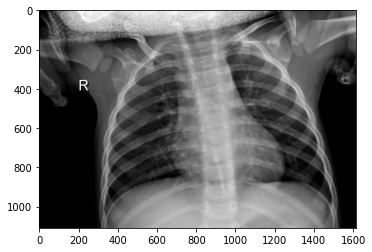

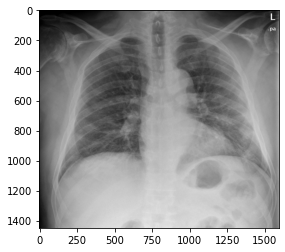

In [51]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

normal_images = [mpimg.imread(img_path) for img_path in glob.glob(data_dir+'/normal/*')]
covid_images = [mpimg.imread(img_path) for img_path in glob.glob(data_dir+'/covid/*')]

plt.imshow(normal_images[0], cmap='gray')
plt.figure()
plt.imshow(covid_images[0], cmap='gray')

In [60]:
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255, 
                                   horizontal_flip=True,
                                   zoom_range=0.2,
                                   height_shift_range=0.2,
                                   width_shift_range=0.2,
                                   fill_mode='nearest',
                                   validation_split=0.25)


train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=(150,150),
                                                    class_mode='binary',
                                                    batch_size=3,
                                                    subset='training')
validation_generator = train_datagen.flow_from_directory(data_dir,
                                                       target_size=(150,150),
                                                       batch_size=3,
                                                       class_mode='binary',
                                                       subset='validation',
                                                       shuffle=True)

Found 74 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-06-18 06:55:09--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   260MB/s    in 0.3s    

2020-06-18 06:55:09 (260 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [62]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(include_top=False, weights=None, input_shape=(150,150,3))
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable=False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [63]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras


x = keras.layers.Flatten()(last_output)

x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=pre_trained_model.input, outputs=x)

In [64]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['accuracy'])

In [65]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 20,
            verbose = 2)

Epoch 1/20
25/25 - 4s - loss: 0.3038 - accuracy: 0.9054 - val_loss: 0.3092 - val_accuracy: 0.9167
Epoch 2/20
25/25 - 3s - loss: 0.1492 - accuracy: 0.9324 - val_loss: 0.0477 - val_accuracy: 0.9583
Epoch 3/20
25/25 - 3s - loss: 0.0511 - accuracy: 0.9865 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 4/20
25/25 - 3s - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 5/20
25/25 - 3s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 6/20
25/25 - 3s - loss: 0.0575 - accuracy: 0.9730 - val_loss: 0.0292 - val_accuracy: 1.0000
Epoch 7/20
25/25 - 3s - loss: 8.8670e-04 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 8/20
25/25 - 3s - loss: 7.0964e-04 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 9/20
25/25 - 3s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0573 - val_accuracy: 0.9583
Epoch 10/20
25/25 - 3s - loss: 0.0110 - accuracy: 0.9865 - val_loss: 0.0155 - val_accuracy: 1.0000
Epoch 11/20

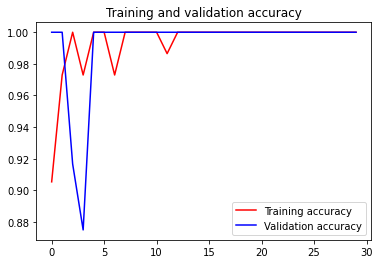

<Figure size 432x288 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [59]:
import numpy as np
label = validation_generator.classes
pred= model.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print (labels)
print (predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
{'covid': 0, 'normal': 1}
['covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid']
